In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data.dataset import MetaDataset
from env import sr
from loss import MelMSE
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
from models import save_model, load_model
from models.vae import ToyVAE
from maml import reptile_train
from data.transform import log_stft, db_to_amp, from_gen_model_output
from data import read_audio
from data.dataset import TaskDataset, InputData
from visualization import plot_spec
from vocoder import griffin_lim

In [24]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()

In [25]:
dataset = MetaDataset(meta_data)
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-21 23:38:35.806146


In [39]:
device = torch.device('cuda')
model = ToyVAE().to(device)

criterion = nn.MSELoss()
# criterion = MelMSE(is_input_log_amp=False, n_mel=1024)
if isinstance(criterion, nn.Module):
    criterion.to(device)

def get_optimizer(model):
    return optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0) # 2e-4
# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
# optimizer = get_optimizer()

def train(model, x, y,
          n_iter=1000, log_period=None):
    optimizer = get_optimizer(model)
    model.train()
    x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    for i in range(n_iter):
        optimizer.zero_grad()
        out = model(x)
        out = out.transpose(0, 1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', loss.item())


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

Source train aligned


Target train aligned


Pass 0 :  1.567060947418213
Pass 200 :  0.15433166921138763
Pass 400 :  0.0557086281478405
Pass 600 :  0.054262351244688034
Pass 800 :  0.052757300436496735
Pass 1000 :  0.05025186017155647
Pass 1200 :  0.04663841053843498
Pass 1400 :  0.042908526957035065
Pass 1600 :  0.0399366095662117
Pass 1800 :  0.0375998318195343
Pass 2000 :  0.035522639751434326
Pass 2200 :  0.03345279023051262
Pass 2400 :  0.03130851313471794
Pass 2600 :  0.029253382235765457
Pass 2800 :  0.027357328683137894
Pass 3000 :  0.025618012994527817
Pass 3200 :  0.024108385667204857
Pass 3400 :  0.02281699702143669
Pass 3600 :  0.02174697443842888
Pass 3800 :  0.020866332575678825
Pass 4000 :  0.02018900215625763
Pass 4200 :  0.019667133688926697
Pass 4400 :  0.01925378479063511
Pass 4600 :  0.01890639401972294
Pass 4800 :  0.018589697778224945
Pass 5000 :  0.018281729891896248
Pass 5200 :  0.017970820888876915
Pass 5400 :  0.017642861232161522
Pass 5600 :  0.01730584166944027
Pass 5800 :  0.01695902831852436
Pass 600

Test estimate


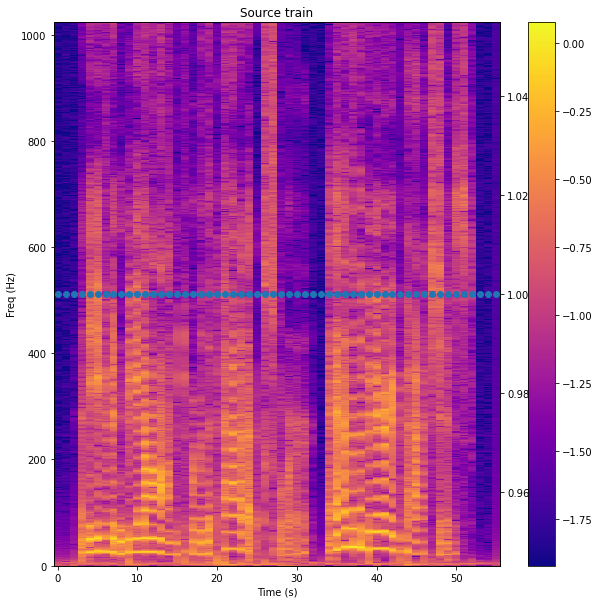

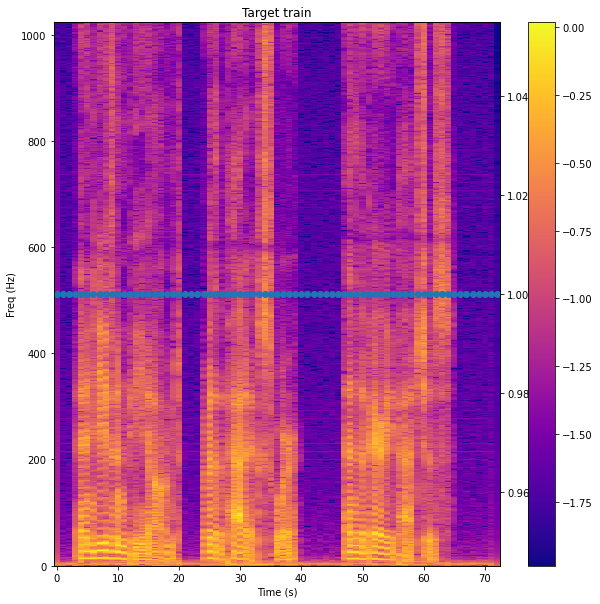

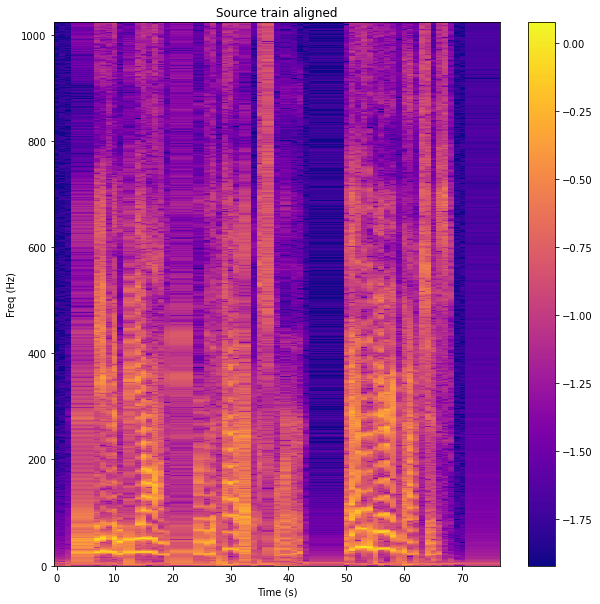

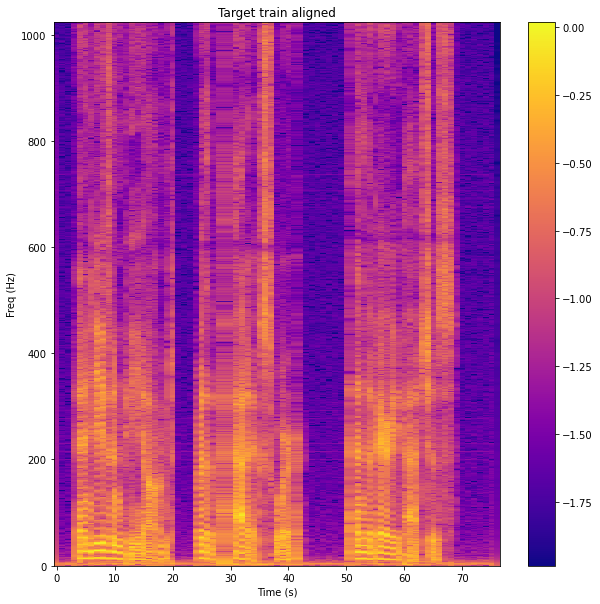

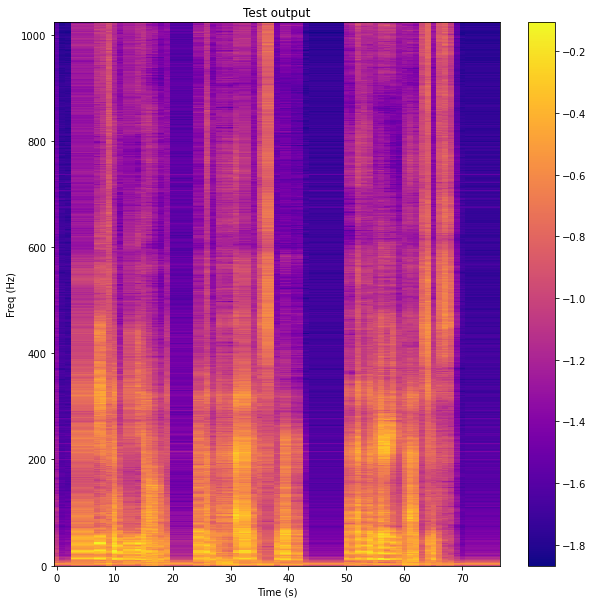

In [6]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

def learnable_test(model, train_source_filename, train_target_filename,
                   vocode=False):
    from data.transform import to_gen_model_output
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    plot_spec(to_gen_model_output(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    plot_spec(to_gen_model_output(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned', figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_x)),
              label='Source train aligned')

    plot_spec(train_y, title='Target train aligned',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_y)),
                  label='Target train aligned')
    train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
          n_iter=7000, log_period=200) # TODO: tune this

    estimated = model(torch.from_numpy(train_x).transpose(0, 1).to(device))
    y = estimated.detach().cpu().numpy().T
    plot_spec(y, title='Test output',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(y)), label='Test estimate')

learnable_test(model, meta_data.get(0, 0), meta_data.get(3, 0), vocode=True)


In [27]:
# Meta train

model = ToyVAE().to(device)
optimizer = get_optimizer()

reptile_train(model, dataset, n_shot=None,
              n_iter_meta=500, meta_step_size=5e-1,
              inner_train_func=train, n_iter_inner=500,
              log_period_meta=5, log_period_inner=100)

save_model('saved_models/' + type(model).__name__ + '.pt', model)

Meta iter 0 : 
Pass 0 :  1.2667185068130493
Pass 100 :  0.7072033882141113
Pass 200 :  0.15391960740089417
Pass 300 :  0.044618334621191025
Pass 400 :  0.03471732139587402
Meta iter 5 : 
Pass 0 :  0.08250518888235092
Pass 100 :  0.07333491742610931
Pass 200 :  0.06849709898233414
Pass 300 :  0.06270694732666016
Pass 400 :  0.054580457508563995
Meta iter 10 : 
Pass 0 :  0.09296062588691711
Pass 100 :  0.04003671556711197
Pass 200 :  0.03843111917376518
Pass 300 :  0.037050407379865646
Pass 400 :  0.0357838049530983
Meta iter 15 : 
Pass 0 :  0.045856233686208725
Pass 100 :  0.037692733108997345
Pass 200 :  0.03491664677858353
Pass 300 :  0.03252677246928215
Pass 400 :  0.030221566557884216
Meta iter 20 : 
Pass 0 :  0.04272134229540825
Pass 100 :  0.03128572925925255
Pass 200 :  0.027383146807551384
Pass 300 :  0.024569422006607056
Pass 400 :  0.022341977804899216
Meta iter 25 : 
Pass 0 :  0.04246394336223602
Pass 100 :  0.0340278185904026
Pass 200 :  0.03152286633849144
Pass 300 :  0.029

In [17]:
print(type(model).__name__)

ToyVAE


In [43]:
# Second train after meta training

pretrained_model = load_model('saved_models/' + type(model).__name__ + '.pt',
                              ToyVAE).to(device)


Source train


Target train


Pass 0 :  0.045949723571538925
Pass 500 :  0.01917090080678463
Pass 1000 :  0.017432713881134987
Pass 1500 :  0.01641467586159706
Pass 2000 :  0.015251521952450275
Pass 2500 :  0.014287449419498444
Pass 3000 :  0.01341783907264471
Pass 3500 :  0.012621421366930008
Pass 4000 :  0.011855225078761578
Pass 4500 :  0.01116510946303606


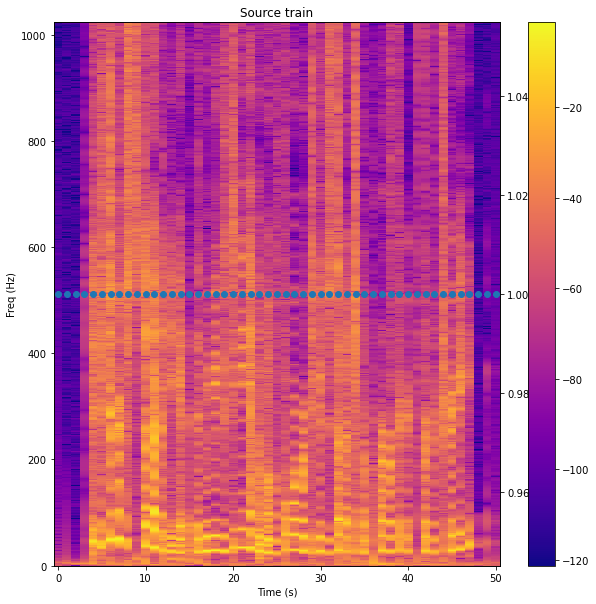

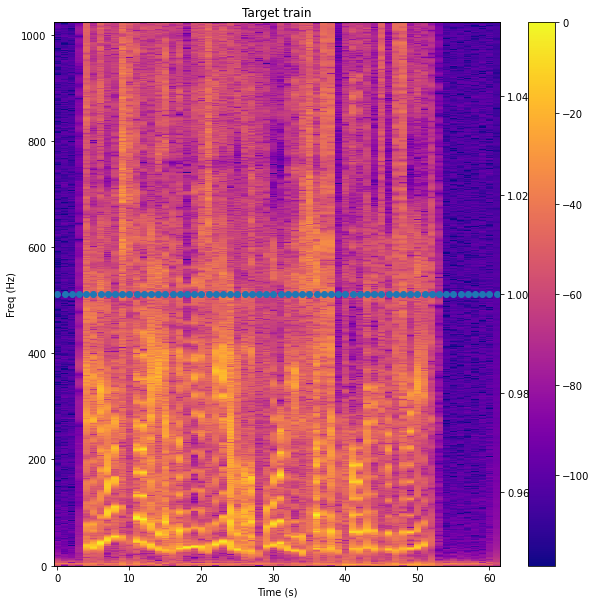

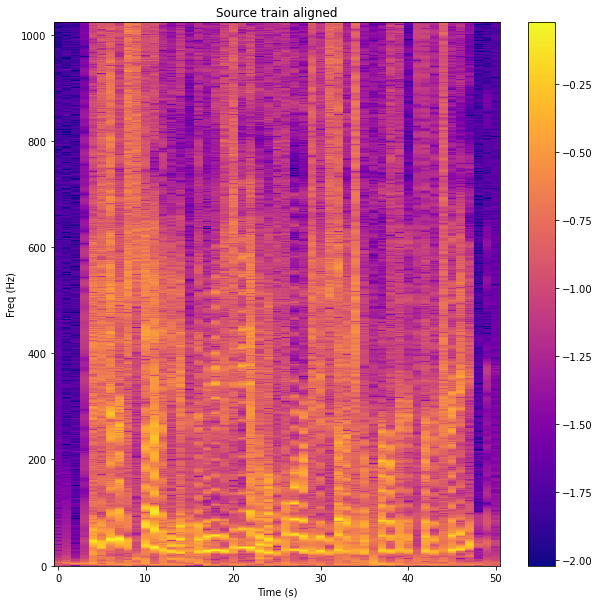

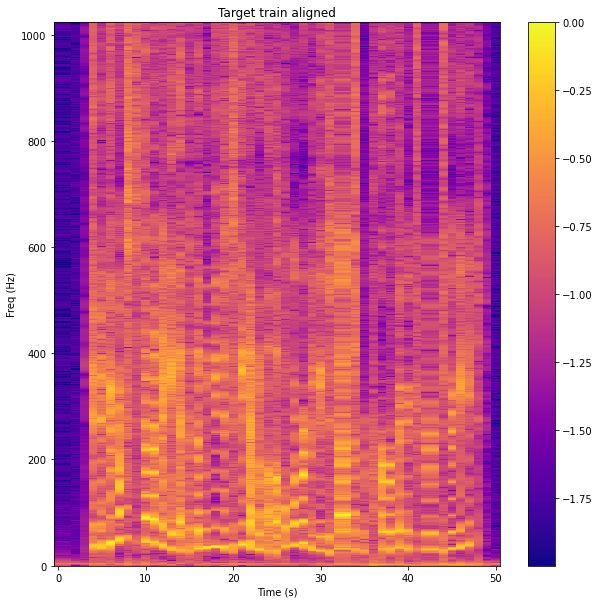

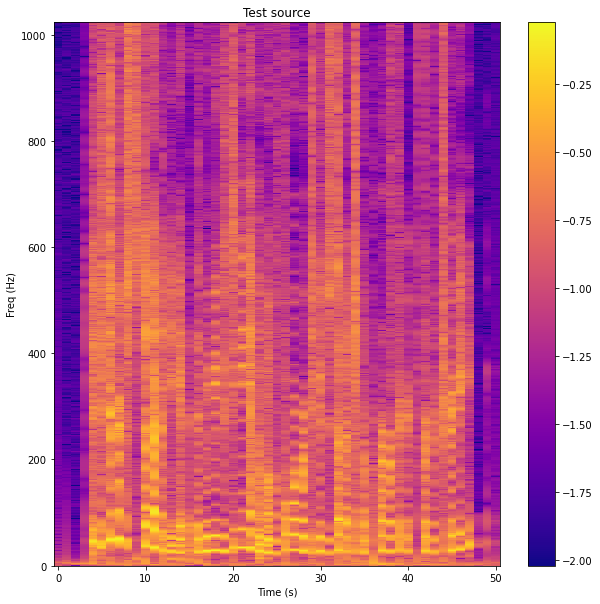

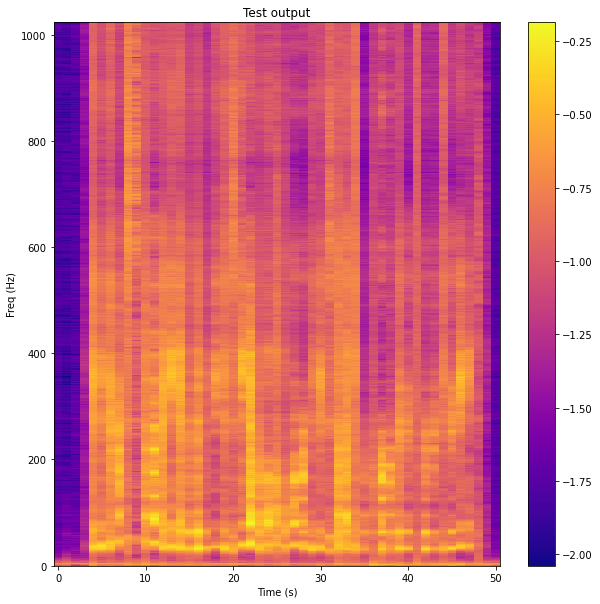

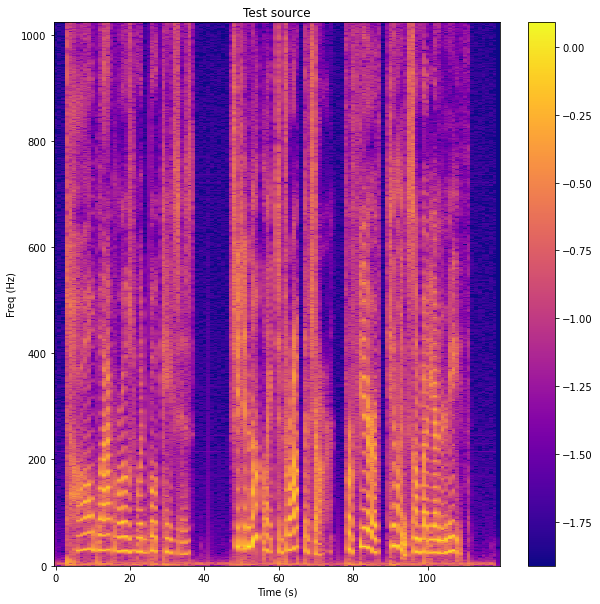

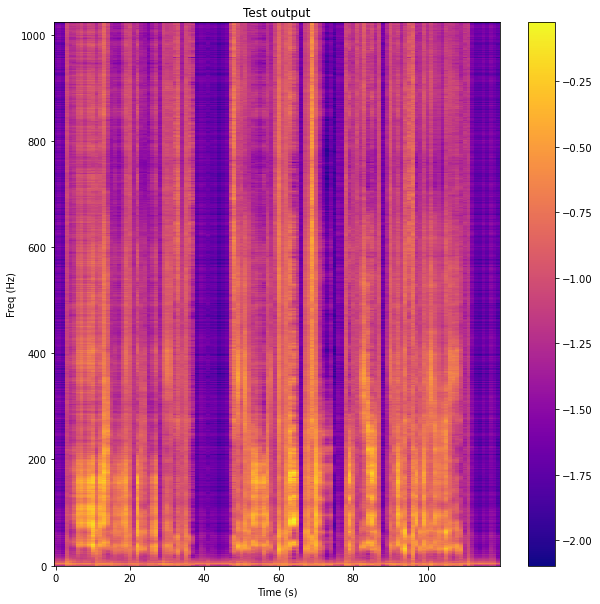

In [45]:
def test(model, train_source_filename, train_target_filename,
         test_input_filename, vocode=False):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned', figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_x)),
              label='Source train aligned')

    plot_spec(train_y, title='Target train aligned',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_y)),
              label='Target train aligned')

    train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
          n_iter=5000, log_period=500)


    def test_sample(x):
        plot_spec(x, title='Test source',
                  figure_size=(10,10))
        x = torch.from_numpy(x.T).to(device)
        estimated = model(x)
        y = estimated.detach().cpu().numpy().T
        # sound(read_audio(test_input_filename), label='Test source')
        plot_spec(y, title='Test output',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(from_gen_model_output(y)), label='Test estimate')

    test_sample(train_x)

    test_sample(input_dat.get())

source_speaker_id = 0
target_speaker_id = 1
train_audio_id = 3
test_audio_id = 5
test(pretrained_model,
     meta_data.get(source_speaker_id, train_audio_id),
     meta_data.get(target_speaker_id, train_audio_id),
     meta_data.get(source_speaker_id, test_audio_id))

In [ ]:
# test with actual samples
